In [1]:
from minisom import MiniSom
import random as r
import copy as cop
import os
import numpy as np

from glob import glob
# import matplotlib as plt


%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [2]:
class SOM:
    def pertWeights( self, scale=.2 ):     
        print( 'Adding noise to SOM weights')
        pertAmount = scale*(np.random.random_sample( self.som.weights.shape)-.5)
        self.som.weights = self.som.weights + pertAmount
    
    def pertData( self, p=.2, verbose=False):
        if verbose:
            print( 'Making %.2f percent of inputs 0.0' %(p*100))
        # randomly get proportion of indices to switch, then replace
        p = max( min(p,1), 0 ) # set in range [0,1]
        
   
#         if skipCols == None:
        
#         else:
#         sh = self.data.shape
#         noiseIndex = np.random.binomial(1,p,(sh[0], sh[1]-1 ) ) 
            
        noiseIndex = np.random.binomial(1,p, self.data.shape)  #ones at p proportion of samples
        self.data[noiseIndex ==1 ] = 0
        #return data
    
    # plot the thing
    def show( self, maxIdx=None):
        print( 'Training exemplar projection')
        som = self.som
        if maxIdx == None:
            maxIdx = len(self.data)
        data= self.data[0:maxIdx]
        target = self.target
        bone()
        pcolor(som.distance_map().T) # plotting the distance map as background
        colorbar()
        t = zeros(len(target),dtype=int)
        t[target == 'A'] = 0
        t[target == 'B'] = 1
        # use different colors and markers for each label
        markers = ['o','s','D']
        colors = ['r','g','b']
        for cnt,xx in enumerate(data):
            w = som.winner(xx) # getting the winner
            # palce a marker on the winning position for the sample xx
            plot(w[0]+.5,w[1]+.5,markers[t[cnt]],markerfacecolor='None',
                markeredgecolor=colors[t[cnt]],markersize=12,markeredgewidth=2)
        axis([0,som.weights.shape[0],0,som.weights.shape[1]])
        show() # show the figure
        
    def showIdeal( self):
        print( 'Ideal exemplar projection')
        som = self.som
        data= self.ideal
        target = self.idealTarget
        bone()
        pcolor(som.distance_map().T) # plotting the distance map as background
        colorbar()
        t = zeros(len(target),dtype=int)
        t[target == 'A'] = 0
        t[target == 'B'] = 1
        # use different colors and markers for each label
        markers = ['o','s','D']
        colors = ['r','g','b']
        for cnt,xx in enumerate(data):
            w = som.winner(xx) # getting the winner
            # palce a marker on the winning position for the sample xx
            plot(w[0]+.5,w[1]+.5,markers[t[cnt]],markerfacecolor='None',
                markeredgecolor=colors[t[cnt]],markersize=12,markeredgewidth=2)
        axis([0,som.weights.shape[0],0,som.weights.shape[1]])
        show() # show the figure        
        
    def train(self, iters = 30):
        self.som.train_random(self.data,iters)
#         print( 'Post training quantization error: %f' % self.som.quantization_error(self.data))

    """def trainOneGliozzi(self):
        # using gliozzi thing
        # init learning params
        self.som.sigma_gliozzi = linspace(1.2, 0.8, num=len(self.data))
        self.som._init_T(len(self.data))   
        
        #  will use the data idx to slowly reduce sigma, and learning rate in update function
        self.som.update_gliozzi(self.data[self.dataIdx],self.som.winner(self.data[self.som.dataIdx]), self.som.dataIdx)

        # update training index (for next time)
        self.dataIdx += 1
        if self.dataIdx >= len(self.data):
            self.dataIdx = 0 
    """
    
    def trainOne(self ):
        """ Trains the SOM picking samples from data one at a time """
        #self.running = True        
        d = self.dataIdx  # data index to train
        self.som._init_T(len(self.data))      
        self.som.update( self.data[d], self.som.winner(self.data[d]), d)  # update
        #self.running = False
        
        # update training index (for next time)
        self.dataIdx += 1
        if self.dataIdx >= len(self.data):
            self.dataIdx = 0        

    def predOne(self, verbose=False):
        # Do the next one prediction
        
        # get BMU index and weight 
        x = self.data[self.dataIdx]        
        bmuW = self.som.weights[self.som.winner(x)]
        protDist = []
        protLab = []
        
        # find distance to all prototypes                    
        for prot,label in self.getProt():                       
            #protMapped = self.som.weights[self.som.winner(prot) ]
            protDist.append( norm( bmuW- prot )) # self.ideal[ idx ])) 
            protLab.append( label )             #  self.idealTarget[idx] )     
                
        # SOM decision  ( random if not close to any prototoype or first trial)
        if len( protDist ) >0:                       
            somLab = protLab[ argmin( protDist ) ]  # nearest category             
            # make random if not like either prototype
            if min(protDist) > self.predThresh:
                somLab = ( 'A' if r.random() > .5 else 'B' )                
        else: # random on first trial
            somLab = ( 'A' if r.random() > .5 else 'B' )
                
        # update SOM accuracy
        trueLab = self.target[self.dataIdx]
        self.somAcc[self.dataIdx] = (1 if somLab==trueLab else 0 )
        
        # get child label
        #  somAcc = (1 if predLab == trueLab else 0 )
        if self.acc[self.dataIdx ] == 1: # if accurate
            childLab = trueLab
        elif np.isnan(self.acc[self.dataIdx ]): # if NaN
            childLab = 'N'
        else: # if wrong
            childLab = 'AB'.strip(trueLab) 
    
        if verbose:
            print( 'Qnt error current Sample: %.4f' % norm(x- bmuW) )            
            print( 'SOM/Child/True Label: %s/%s/%s.' % (  somLab, childLab, trueLab)  )
            print( 'Project prototype distances: ' )
            print protDist, protLab
        return ( somLab, childLab ) 

    def predAll(self, reset = True, skip =0, verbose= True, reps=1 ):
        
        fullSomList = np.array([])
        fullChildList = np.array([])
        
        for numRepetitions in range(reps): # repeat for random initialization of som            
            # initialize som weights, and data index if reset=True
            if reset:
                self.initWeights()                
                self.dataIdx = 0 # to index what data sample for one shot learning
            
            # init for storing results
            somList = np.chararray(len(self.data)) #*np.nan
            childList = np.chararray(len(self.data)) #*np.nan
            # go through each trial and predict
            for idx in range(len(self.data)):          
                #predict
                somLab, childLab = self.predOne()
                somList[idx] = somLab
                childList[idx] = childLab
                # train
                self.trainOne()  #  don't use mod.trainOneGliozzi()

            # deal with missing values and skip first if requested
            somList = somList[skip:]  # kick out first skip samples
            childList = childList[skip:] # kick out first skip samples        
            somList = somList[ childList != 'N'] # N for nan
            childList = childList[ childList != 'N']
            
            # store in the big list
            fullSomList = np.concatenate( (fullSomList, somList), axis=1)
            fullChildList = np.concatenate( (fullChildList, childList), axis=1)
        
        # get how well model does
        if len(fullChildList) >0:
            scAgreement = float(np.sum( fullSomList==fullChildList))/len(fullSomList)
        else:
            scAgreement = np.nan
            
        if verbose:
            print 'SOM pred: ', fullSomList
            print 'Inf pred: ', fullChildList            
            print('SOM and infant agree %.2f of time' % scAgreement )
        return fullSomList == fullChildList

    
    
    def separation( self):
        """return the norm of the difference vector between the mean of projected idealized class
            A exemplars, and class B exemplars.  Essentially, the separation between those classes 
            May need to include a variance normalization in future. """
        A =  self.ideal[ self.idealTarget=='A']
        B =  self.ideal[ self.idealTarget=='B']
        projA = numpy.empty(A.shape) * numpy.nan
        projB = numpy.empty(B.shape) * numpy.nan
        # go through all catA
        for idx,x in enumerate(A):
            projA[idx] = mod.som.weights[mod.som.winner(x)]
        for idx,x in enumerate(B):
            projB[idx] = mod.som.weights[mod.som.winner(x)]
        diff = linalg.norm(projA.mean(axis=0)-projB.mean(axis=0) ) 
        
        # pooled variance estimate (not standard, since using average variance across dimensions for a class)
        pVar = pVar = (projA.var(axis=0).mean() + projB.var(axis=0).mean() )/2  
        
        return diff/np.sqrt( pVar)
    
    def getProt( self, idealProt = False ):
        prot = []
        label = []    
        
        # use true prototypes from ideal data
        if idealProt:
            for idx in self.protIdx:
                prot.append(self.ideal[idx,:])
                label.append(self.idealTarget[idx])        
        # estimate prototypes based in training data
        else:
            # get data/labels just until the current iteration (data is projected onto SOM)
            targTemp = self.target[:self.dataIdx]
            dataTemp = self.som.quantization( self.data[:self.dataIdx,:] ) # projected samples
            
            # loop through all labels, calc prototypes by average
            for t in np.unique(targTemp):    
                prot.append(np.mean( dataTemp[ targTemp==t, :], axis=0 ))  # mean of category
                label.append(t) # corresponding label                
        return zip(prot,label )   
        
    def initWeights(self, scale=1 ):
        """ Initializes the weights of the SOM randomly around 0 """        
        self.som.weights =scale*(np.random.random_sample( self.som.weights.shape)-.5)


    def showLearnCuves(self, window=6):
        curveSOM = slideAcc( self.somAcc, window )
        curveSubj = slideAcc( self.acc, window )
        plot( np.arange(len(curveSOM)) ,curveSOM, 'k.-', linewidth=3, label='SOM')
        plot( np.arange(len(curveSubj)), curveSubj, 'g--', linewidth=3, label='prt')
        plot( np.arange(0,50), np.ones(50)*.5,'r-', linewidth=2, label='chance')
        xlabel('trial')
        legend()
        self.curveSOM = curveSOM
        self.curveSubj = curveSubj
        
    
    def meanLrnCurves( self, iters = 10, removeProp = 0  ):
        # backup ori data, init acc vector
        dataOri = cop.copy(self.data)
        accSum = np.zeros(len(self.acc))
        
        for i1 in range(iters):
            # train/predict SOM several times            
            self.data = cop.copy(dataOri)
            self.pertData(removeProp)  #not perfect data to train                      
            agreement = self.predAll( verbose=False, skip=0, reps=1)     
            accSum =accSum + self.somAcc
        self.somAcc = accSum/iters # average accuracy
        
        # return accuracy
        return self.somAcc
    
    #-------------------------------------------------
    
    def __init__(self, file_name='4750.csv', columns = [0,1,2,3,4,5,6,7], width = 6, height = 5, sigma=1.2,  learning_rate=0.5, predThresh=np.inf ):
        
        #       self.visual_only = [0,1,2,3,4,5,6,7]
        #       self.visual_and_acoustic = [0,1,2,3,4,5,6,7,8]

        # load data and normalization
        self.data = np.genfromtxt( file_name, delimiter=',',usecols=columns, skip_header=1)        
        self.data *= 2.0 
        self.data += -1.0  # -0.5 
        # get target labels
        self.target = genfromtxt(file_name,delimiter=',',usecols=(9),dtype=str, skip_header=1) # loading the labels
        #get infant accuracy
        self.acc = genfromtxt(file_name,delimiter=',',usecols=(10),dtype=float, skip_header=1) 
        self.somAcc = self.acc*np.nan
        
        # init som
        self.som = MiniSom(width, height, self.data.shape[1], sigma=sigma,learning_rate=learning_rate)
        #self.som.random_weights_init(self.data)
        self.initWeights()  
        self.dataIdx = 0 # to index what data sample for one shot learning
        
        # get idealized data
        self.ideal = np.genfromtxt( 'stimuli.csv', delimiter=',',usecols=columns, skip_header=1) 
        self.ideal *= 2.0 
        self.ideal += -1.0  # -0.5 
        self.idealTarget = genfromtxt('stimuli.csv',delimiter=',',usecols=(9),dtype=str, skip_header=1) # loading the labels
               
        # index of ideal samples that are category prototypes
        self.protIdx = np.array([6,7])
        self.predThresh = predThresh  # when classifying, if distance larger than this then random decision


#------------------------------------------------------------------

# def getIdeal( file_name='stimuli.csv', columns = [0,1,2,3,4,5,6,7]): 
#     # return the ideal data for checking quantization error
#     data = np.genfromtxt( file_name, delimiter=',',usecols=columns, skip_header=1)     
#     return ( data[:7,:], data[7:,:] )


def slideAcc( acc, window=6 ):
    # return a sliding window average of accuracy 
    N = len(acc)
    wAcc = np.zeros((N))*np.nan
    for i1 in range(window,N+1):      
        a = acc[i1-window:i1]
        #print i1, a
        wAcc[i1-1] = nanmean(a) # get mean over window    
    return wAcc


Training exemplar projection


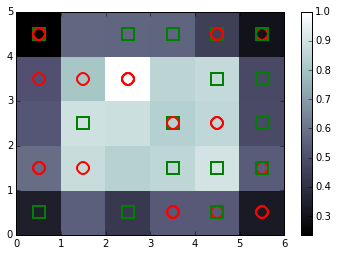

Ideal exemplar projection


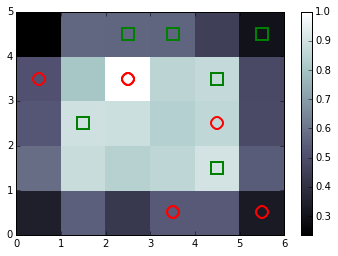

In [3]:
# init som
# f = '4750.csv'


# fileDir = '../../KARS_reinf/Python/FeatIdealAdultBL/'

# fileDir = '../../KARS_reinf/Python/FeatSeenBySubAdultBL/'

# fileDir = '../../KARS_reinf/Python/FeatSeenBySubBaseline/'
# fileDir = '../../KARS_reinf/Python/FeatSeenBySubLabel/'
# fileDir = '../../KARS_reinf/Python/FeatSeenBySubSup/'
# files = glob( fileDir + '*.csv') #fileDir+'4760.csv'


f = 'adultIdealInput.csv'

mod = SOM( f, learning_rate=0) #, predThresh=.9) 
mod.pertData(.7)
mod.show()
mod.showIdeal()





Qnt error current Sample: 1.0631
SOM/Child/True Label: A/A/A.
Project prototype distances: 
[] []
Iter 1
Training exemplar projection


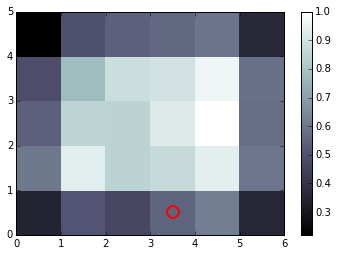

Ideal exemplar projection


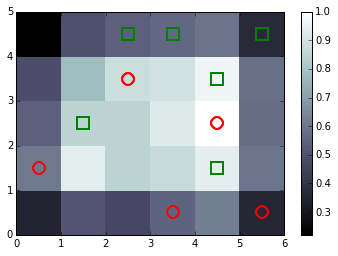

In [4]:
# train incrementally example  (keep running this cell to keep training 1 at a time)

somLab, childLab = mod.predOne( verbose=True)
mod.trainOne()  #  don't use mod.trainOneGliozzi()
print( 'Iter %d'% mod.dataIdx )

mod.show(mod.dataIdx)
mod.showIdeal()  # ideal exemplars on trained map




Training exemplar projection


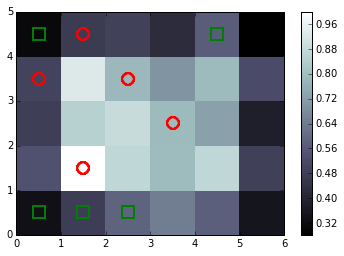

Training exemplar projection


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:177: DeprecationWarning: axis != 0 for ndim == 1; this will raise an error in future versions of numpy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:178: DeprecationWarning: axis != 0 for ndim == 1; this will raise an error in future versions of numpy


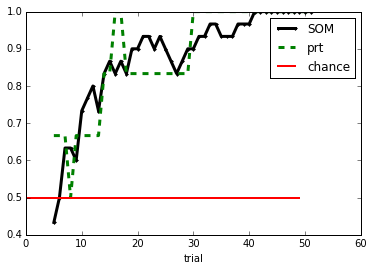

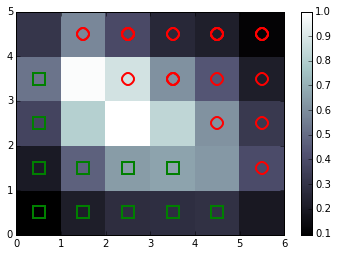

Class separation: 14.13


In [5]:
#####  Calculate learning curve (several initializations)


# f = files[1]
removeProp = .4 #5
lrnRt = .3
iters = 5 # 30



mod = SOM( f, learning_rate= lrnRt, predThresh=.7)


# show untrained map
mod.show()

# show curves
figure()
mod.meanLrnCurves( iters = iters, removeProp = removeProp  )
mod.showLearnCuves(window=6)

#show trained map
figure()
mod.show()
print( 'Class separation: %.2f' %mod.separation())

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:177: DeprecationWarning: axis != 0 for ndim == 1; this will raise an error in future versions of numpy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:178: DeprecationWarning: axis != 0 for ndim == 1; this will raise an error in future versions of numpy


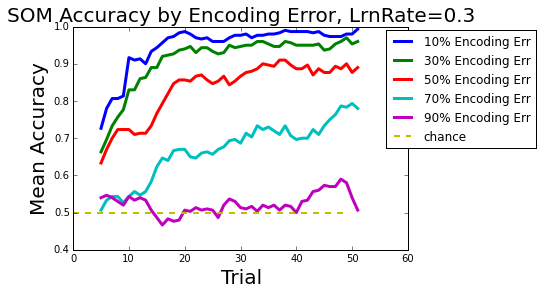

In [6]:
# make some nice larning curves (for encoding error)

# self.somAcc



# f = files[1]
lrnRt = .3
iters = 50 # 30
w = 6

# for saving figures
outDir = 'SOMfigs/'
if not os.path.exists( outDir ):
    os.mkdir( outDir )         

##-------------------------------------------------

# loop through different removeProp (% encoding error)
for removeProp in np.arange(.1,1, .2):                       
    mod = SOM( f, learning_rate= lrnRt, predThresh=.7)
    meanAcc  = mod.meanLrnCurves( iters = iters, removeProp = removeProp  )
    # show them 
    plot( slideAcc( meanAcc, window=w), linewidth=3, label=('%.0f%% Encoding Err'% (100*removeProp)))
# chance line    
plot( np.arange(50), .5*ones(50 ), '--', linewidth=2, label='chance')    
xlabel('Trial', fontsize=20)
ylabel( 'Mean Accuracy', fontsize=20)
title('SOM Accuracy by Encoding Error, LrnRate=0.3', fontsize=20)
# show legend
lgd = legend(bbox_to_anchor=(1.4, 1.01)) 

# save it  
saveFile = outDir + 'removePropFig.png'
savefig( saveFile, bbox_extra_artists=(lgd,), bbox_inches='tight')







# mod.showLearnCuves(window=w)
# for acc in allAcc:
#     plot( acc)




/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:177: DeprecationWarning: axis != 0 for ndim == 1; this will raise an error in future versions of numpy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:178: DeprecationWarning: axis != 0 for ndim == 1; this will raise an error in future versions of numpy


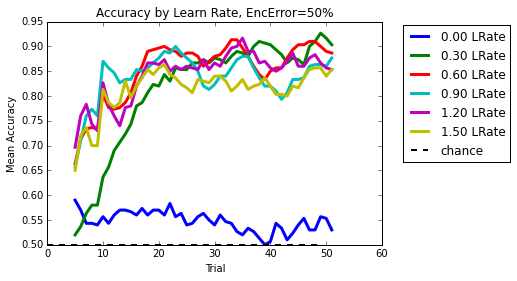

In [7]:
##-------------------------------------------------
# plot function of learning rate


removeProp = .5

figure()
# loop through different learning rates % fixed encoding error

for lrnRt in np.arange(.0,1.8, .3):                       
    mod = SOM( f, learning_rate= lrnRt, predThresh=.7)
    meanAcc  = mod.meanLrnCurves( iters = iters, removeProp = removeProp  )
    # show them 
    plot( slideAcc( meanAcc, window=w), linewidth=3, label=('%.2f LRate'% (lrnRt)))
# chance line    
plot( np.arange(50), .5*ones(50 ), '--', linewidth=2, label='chance')    
xlabel('Trial')
ylabel( 'Mean Accuracy')
title('Accuracy by Learn Rate, EncError=50%')
# show legend
lgd = legend(bbox_to_anchor=(1.4, 1.01)) 

# save it  
saveFile = outDir + 'lrnRate.png'
savefig( saveFile, bbox_extra_artists=(lgd,), bbox_inches='tight')


In [8]:
# run the model fitting N times, get mean class separation
N = 20
sepList = np.arange(N,dtype=float)
for i1 in range(N):
    mod = SOM(f)
    mod.train(20)
    sepList[i1] = mod.separation()

sepList.mean()
# mod.show()
# mod.showIdeal()


15.992145838578654